<a href="https://colab.research.google.com/github/Pentuhov/PR.AI-3/blob/main/%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%94%D0%97_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
import numpy as np
import tensorflow as tf
import random
import os

# Значение seed
seed_value = 12475

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)


In [ ]:
import numpy as np    # Работа с массивами

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Генератор аугментированных изображений
from tensorflow.keras.models import Sequential      # Основа для создания последовательной модели

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam   # Оптимизатор

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Матрица ошибок классификатора

import gdown                     # Подключение модуля для загрузки данных из облака
import os                        # Инструменты для работы с файлами
import matplotlib.pyplot as plt  # Отрисовка графиков
%matplotlib inline

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (1.0, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 150                    # Число эпох обучения
BATCH_SIZE          = 24                     # Размер батча для обучения модели
OPTIMIZER           = Adam(0.00008)          # Оптимизатор

In [ ]:
# Подключение модуля для загрузки данных из облака
import gdown

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [ ]:
# Разархивация датасета в директорию 'content/cars'
!unzip -qo "middle_fmr.zip" -d /content/cars

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/cars/'

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    #rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   preprocessing_function=preprocess_input,
                   #rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    #target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    #target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    #target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

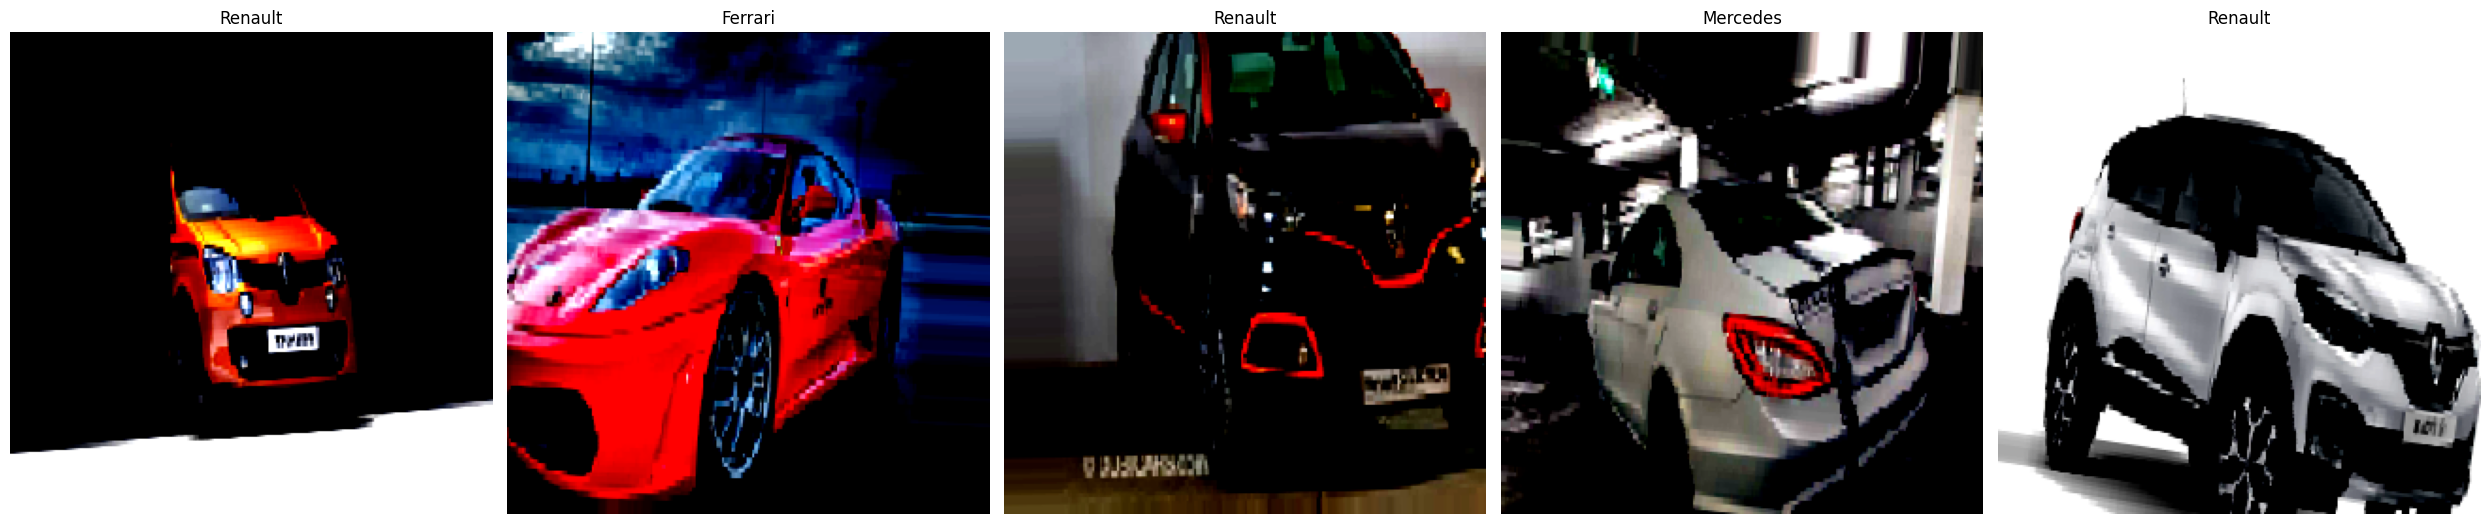

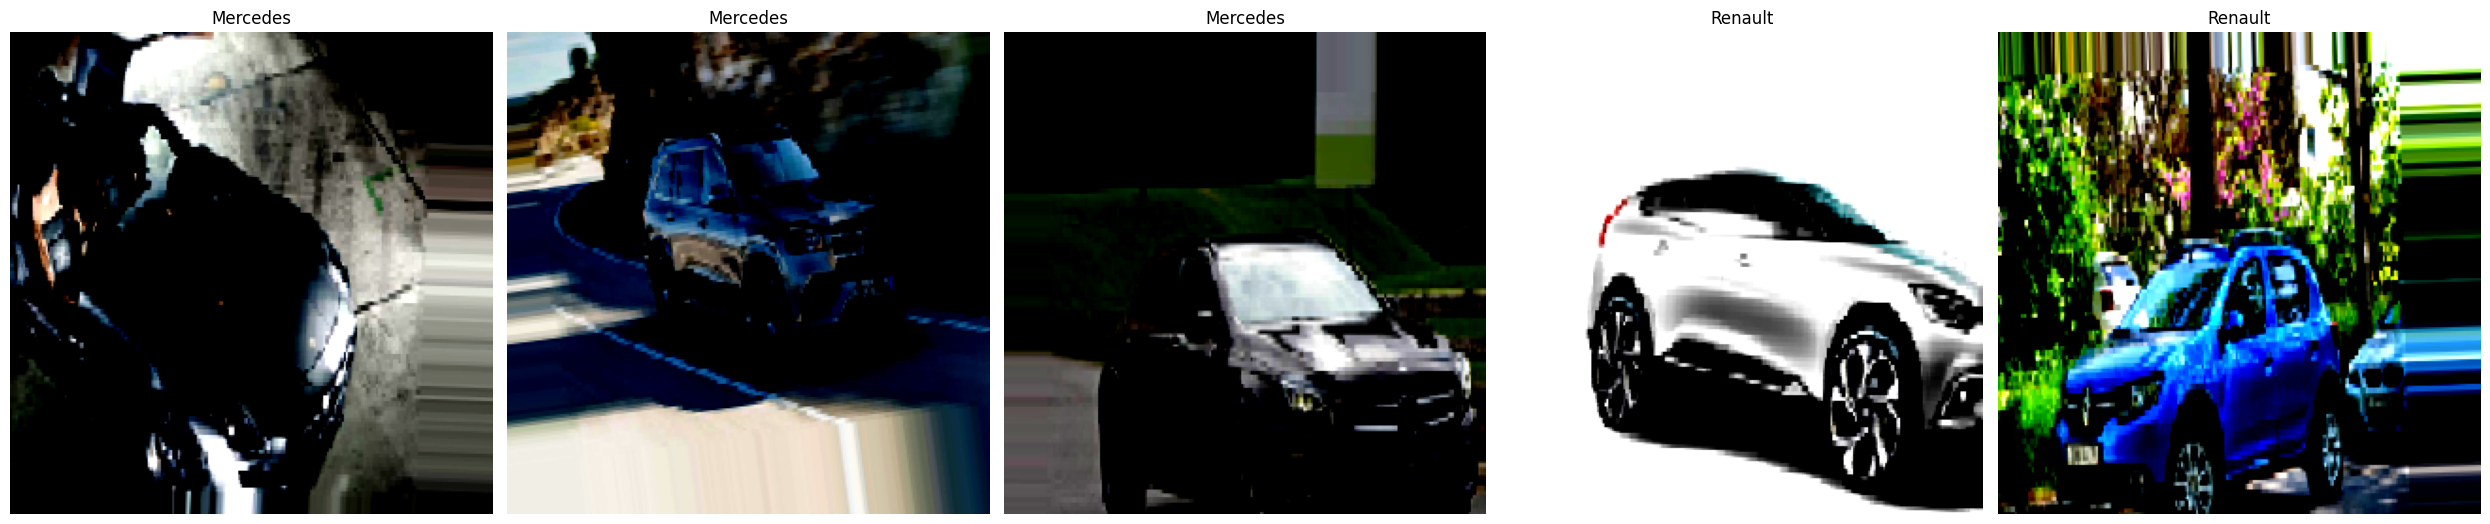

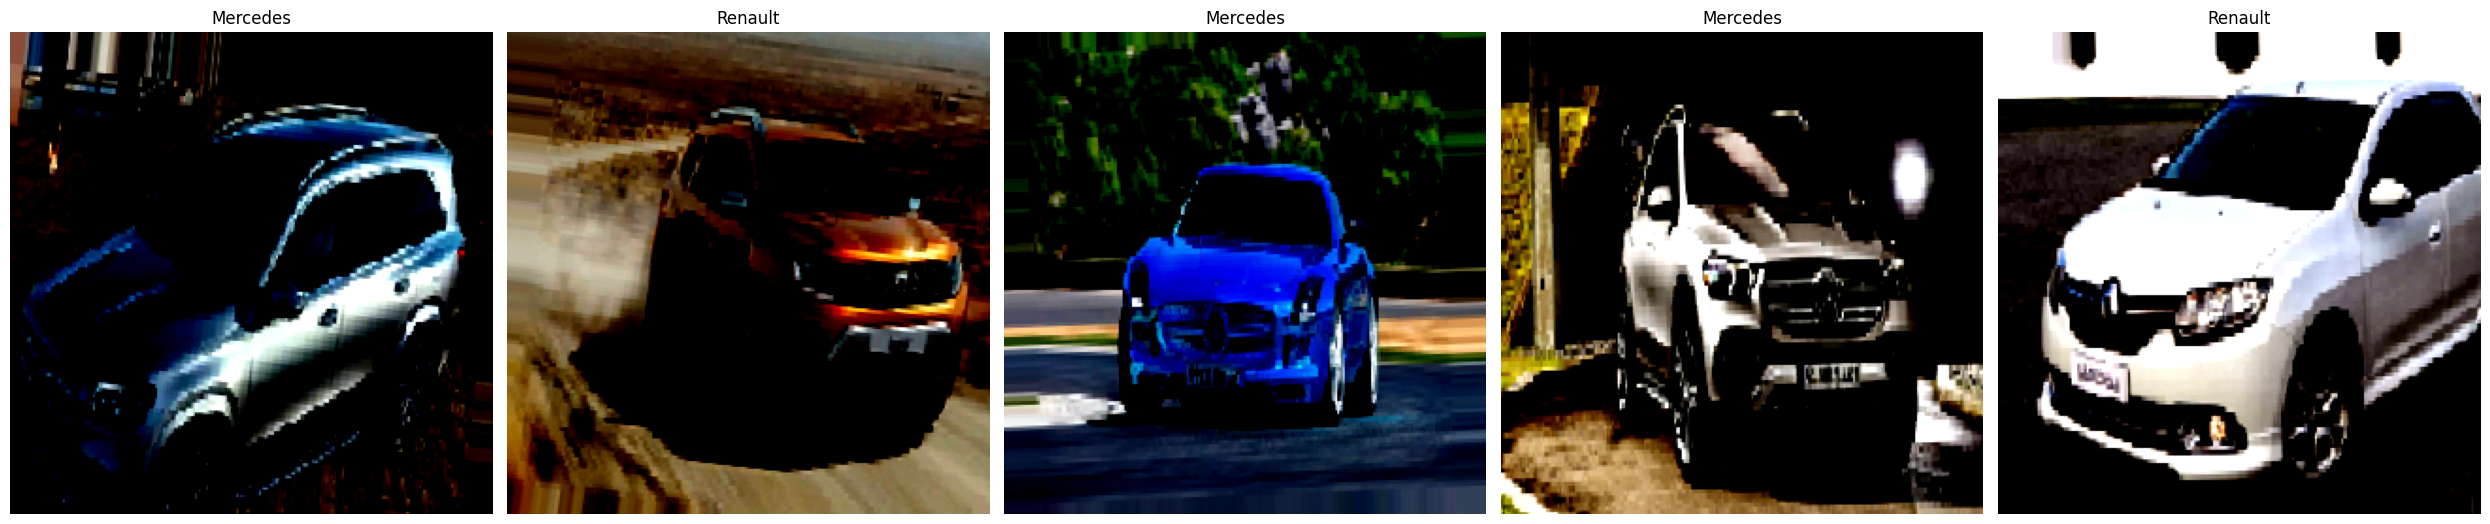

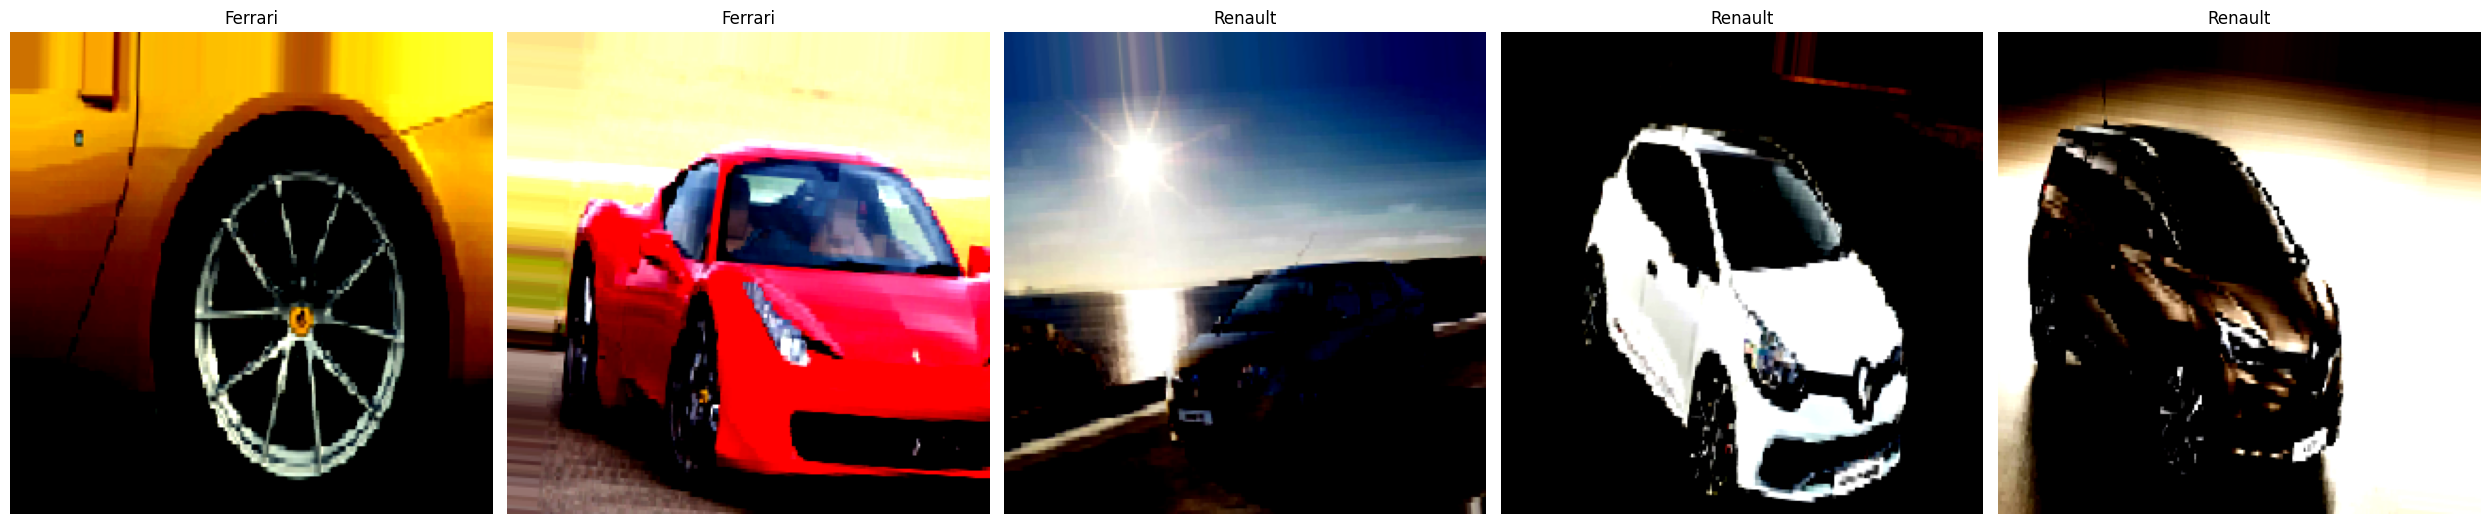

In [ ]:
#Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

In [ ]:
# Загрузка предварительно обученной модели InceptionV3 без верхних слоев
base_model = InceptionV3(weights='imagenet', include_top=False)

# Добавление новых полносвязных слоев для классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(CLASS_COUNT, activation='softmax')(x)

# Создание модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Замораживаем все слои базовой модели
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Обучение модели на новых данных в течение нескольких эпох
model.fit(train_generator,
          epochs=10,
          batch_size=BATCH_SIZE,
          validation_data=validation_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 93s 741ms/step - accuracy: 0.6405 - loss: 1.0402 - val_accuracy: 0.7407 - val_loss: 0.6406
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 545ms/step - accuracy: 0.7958 - loss: 0.5028 - val_accuracy: 0.7147 - val_loss: 0.6942
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 55s 534ms/step - accuracy: 0.7818 - loss: 0.5066 - val_accuracy: 0.6191 - val_loss: 0.8240
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 543ms/step - accuracy: 0.8074 - loss: 0.4790 - val_accuracy: 0.7974 - val_loss: 0.5128
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 55s 533ms/step - accuracy: 0.8222 - loss: 0.4279 - val_accuracy: 0.7650 - val_loss: 0.5632
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step - accuracy: 0.8454 - loss: 0.4119 - val_accuracy: 0.7699 - val_loss: 0.5578
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 540ms/step - accuracy: 0.8560 - loss: 0.3865 - val_accuracy: 0.7715 - val_loss: 0.5216
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 82s 541ms/step - accuracy: 0.8374 - loss: 0

In [ ]:
# Вывод имен и индексов слоев базовой модели InceptionV3
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

In [ ]:
# Размораживаем последние 2 блока InceptionV3, замораживаем остальные слои
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Перекомпилируем модель для учета этих изменений
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем модель снова (в этот раз донастраивая последние 2 блока InceptionV3 вместе с верхними полносвязными слоями)
model.fit(train_generator,
          epochs=30,
          batch_size=BATCH_SIZE,
          validation_data=validation_generator)


Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 94s 718ms/step - accuracy: 0.6819 - loss: 0.7039 - val_accuracy: 0.7893 - val_loss: 0.5392
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 553ms/step - accuracy: 0.8228 - loss: 0.4690 - val_accuracy: 0.7974 - val_loss: 0.5065
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 541ms/step - accuracy: 0.8434 - loss: 0.4146 - val_accuracy: 0.7942 - val_loss: 0.5225
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step - accuracy: 0.8551 - loss: 0.3779 - val_accuracy: 0.8217 - val_loss: 0.4648
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step - accuracy: 0.8686 - loss: 0.3544 - val_accuracy: 0.7974 - val_loss: 0.4983
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 552ms/step - accuracy: 0.8781 - loss: 0.3313 - val_accuracy: 0.8120 - val_loss: 0.4611
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 58s 563ms/step - accuracy: 0.8835 - loss: 0.3053 - val_accuracy: 0.8282 - val_loss: 0.4560
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 557ms/step - accuracy: 0.8773 - loss: 0

In [ ]:
# Оценка точности модели на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - accuracy: 0.8974 - loss: 0.2844
Test Accuracy: 0.8973606824874878
